# Advanced Concatenation
## Sequencing primitive gates to a Hadamard
In this example we want implement a Hadamard gate,

$$
    \text{H}\doteq\frac{1}{\sqrt{2}}
        \begin{pmatrix}
            1 &  1 \\
            1 & -1
        \end{pmatrix},
$$

using $\pi/2$ rotations about the $x$- and $y$-axis of the Bloch sphere, $\pi/2_x$ and $\pi/2_y$, once with optimized gates and once with primitive ones. The Hadamard transform is given by

$$
    \text{H} = \pi/2_x \circ \pi/2_x \circ \pi/2_y.
$$

The optimized gates we shall use are the exchange-based singlet-triplet qubit gates presented in [Cerfontaine et al. (2019)]. For a single qubit, the control Hamiltonian reads

$$
    {H}_c = \Delta B_z \frac{\sigma_x}{2} + J(\epsilon)\frac{\sigma_z}{2}
$$

with $\Delta B_z$ the magnetic field gradient and $J(\epsilon) = \exp(\epsilon)$ the exchange coupling a function of the controllable detuning. Note again that, since we use $\hbar\equiv 1$, all energies have units of inverse time, $\text{ns}^{-1}$ in this case.

[Cerfontaine et al. (2019)]: https://arxiv.org/abs/1901.00851

In [1]:
import sys
from pathlib import Path

import numpy as np
from scipy.io import loadmat

import filter_functions as ff

%matplotlib notebook

In [2]:
data_path = Path(sys.path[0]).parent.parent.parent / 'examples/data'
gates = ['X2', 'Y2']
# Set up Hamiltonian for X2, Y2 gate
struct = {'X2': loadmat(str(data_path / 'X2ID.mat')),
          'Y2': loadmat(str(data_path / 'Y2ID.mat'))}
eps = {key: np.asarray(struct[key]['eps'], order='C') for key in gates}
delta_t = {key: np.asarray(struct[key]['t'].ravel(), order='C')
           for key in gates}
B = {key: np.asarray(struct[key]['B'].ravel(), order='C') for key in gates}

J = {key: np.exp(eps[key]) for key in gates}
n_dt = {key: len(delta_t[key]) for key in gates}

# Total duration of the pulses
tau = delta_t['X2'].sum()

Since $J$ depends non-trivially on $\epsilon$, we include the first derivative as a sensitivity to charge noise on $\epsilon$ in the noise Hamiltonian ${H}_n = \sum_\alpha s_\alpha(t) b_\alpha(t) B_\alpha$.

In [3]:
# Set up the Hamiltonian for the PulseSequence
d = 2
H = np.empty((2, d, d), dtype=complex)

Id, Px, Py, Pz = ff.util.paulis
H[0] = 1/2*Px
H[1] = 1/2*Pz

opers = list(H)

# Assume noise only on eps
c_opers = opers.copy()
n_opers = opers[:1]

# The coefficients we are interested in are the first index (the gates we
# loaded are actually two-qubit gates with an identity gate on the second
# qubit).
c_coeffs = {key: [J[key][0], B[key][0]*np.ones(n_dt[key])]
            for key in gates}
# Noise sensitivity J(eps) for eps.
n_coeffs = {key: [J[key][0], np.ones(n_dt[key])] for key in gates}

# Identifiers for the operators. We can also use verbose strings
identifiers = [r'$\epsilon$', '$b$']

H_c = {key: {'optimized': list(zip(c_opers, val, identifiers))}
       for key, val in c_coeffs.items()}
H_n = {key: {'optimized': list(zip(n_opers, val, identifiers))}
       for key, val in n_coeffs.items()}
dt = {key: {'optimized': val} for key, val in delta_t.items()}

For the primitive pulses, we assume to have full control over the $x$- and $y$-axes of our qubit and simply turn on the control at $t=0$ and turn it off once the $\pi/2$ rotation is complete. In order to better compare the primitive to the optimized pulses, we assume they are of equal duration `tau` and adjust the control strength of the primitive pulses accordingly.

In [4]:
H_c['X2']['primitive'] = [[1/2*Px, [np.pi/2/tau], '$X$']]
H_n['X2']['primitive'] = [[Pz, [1], '$Z$']]
dt['X2']['primitive'] = [tau]
H_c['Y2']['primitive'] = [[1/2*Py, [np.pi/2/tau], '$Y$']]
H_n['Y2']['primitive'] = [[Pz, [1], '$Z$']]
dt['Y2']['primitive'] = [tau]

## Calculating the pulse correlation filter functions
Finally, we can set up the `PulseSequence`s and compute the (fidelity) filter functions. For the Hadamard pulse, we will set an additional flag during concatenation to calculate the 'pulse correlation filter function' which captures the cross-correlational effects of individual pulses on the total pulse sequence's susceptibility to noise.

In [5]:
gate_types = ('optimized', 'primitive')
X2 = {key: ff.PulseSequence(H_c['X2'][key], H_n['X2'][key], dt['X2'][key])
      for key in gate_types}
Y2 = {key: ff.PulseSequence(H_c['Y2'][key], H_n['Y2'][key], dt['Y2'][key])
      for key in gate_types}

omega = {'optimized': np.linspace(0, 1/tau*1e2, 501),
         'primitive': np.linspace(0, 1/tau*2e1, 501)}

# %% Get the filter functions
FF_X2 = {key: val.get_filter_function(omega[key]) for key, val in X2.items()}
FF_Y2 = {key: val.get_filter_function(omega[key]) for key, val in Y2.items()}
H = {key: ff.concatenate((Y2, X2, X2), calc_pulse_correlation_FF=True)
     for (key, X2), (key, Y2) in zip(X2.items(), Y2.items())}

# Note that we can also slice PulseSequence objects, eg
# X = H['primitive'][1:]
# or
# segments = [segment for segment in H['primitive']]

To verify the pulses, we plot the Bloch vector evolution starting from $|0\rangle$. In this case, we expect the pulse to have the action

$$
    \text{H}\colon |0\rangle\to \frac{|0\rangle + |1\rangle}{\sqrt{2}}\equiv |+\rangle.
$$


<IPython.core.display.Javascript object>


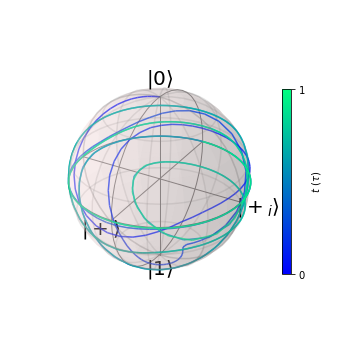

<IPython.core.display.Javascript object>


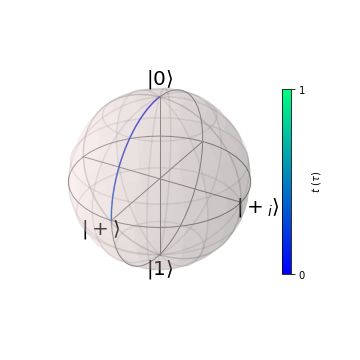

In [6]:
from filter_functions import plotting

for gate in gate_types:
    plotting.plot_bloch_vector_evolution(H[gate], n_samples=501,
                                         figsize=(5, 5), add_cbar=True)

We can now inspect the pulse correlation filter functions $F^{(gg')}(\omega)$ which for $g=g'$ are just the normal filter functions for the $g$-th pulse:

<IPython.core.display.Javascript object>


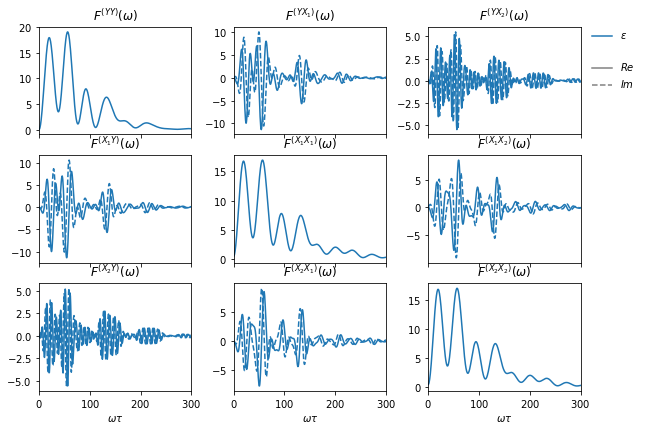

<IPython.core.display.Javascript object>


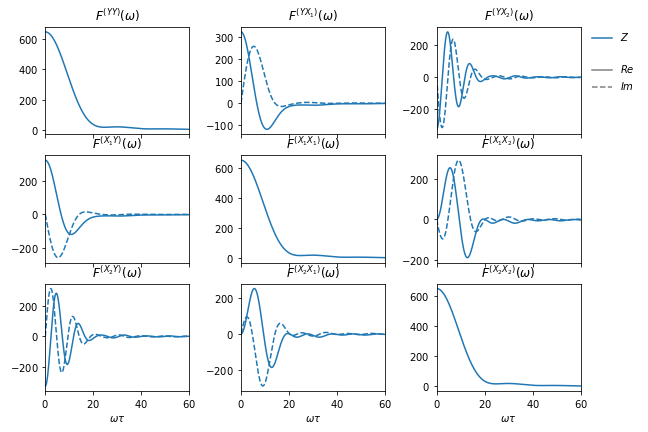

In [7]:
pulses = ('Y', 'X_1', 'X_2')
for gate_type, hadamard in H.items():
    fig, ax, leg = plotting.plot_pulse_correlation_filter_function(
        hadamard, xscale='linear', figsize=(9, 6))

    # Adjust the titles to something more meaningful
    for i in range(3):
        for j in range(3):
            t = ax[i, j].get_title()[7:]
            ax[i, j].set_title('$F^{(' + pulses[i] + pulses[j] + t)

We can see that the pulse correlation filter functions for different pulses are neither strictly real nor positive in contrast to the 'usual' filter functions. In fact, the pulse correlation FF are hermitian, that is,

$$
\left[F^{(ij)}(\omega)\right]^\dagger = F^{(ij)}(\omega).
$$

While the imaginary part cancels out when calculating fidelities, $\mathcal{I}\propto\sum_{ij} \int\mathrm{d}\omega S(\omega)F^{(ij)}(\omega)$, the real part does not and the offdiagonals therefore lead to corrections in the total fidelity of a composite pulse, $\mathcal{I}_\text{tot}\neq\sum_g\mathcal{I}^{(g)}$ with $\mathcal{I}^{(g)}$ the infidelities of the individual pulses. These corrections can thus in principle also be negative, leading to improved fidelities for composite pulses.